In [83]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# Constants
ANALYSIS_PERIOD_YEARS = 10
CONFIDENCE_LEVEL = 0.95
TRADING_DAYS = 252

# Risk Free Rate
tbill = yf.download("^IRX", period="1wk", auto_adjust=False)
risk_free_rate = (tbill['Adj Close'].tail(5).mean() / 100).iloc[0]


[*********************100%***********************]  1 of 1 completed


In [84]:
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=365*ANALYSIS_PERIOD_YEARS)
etfs = ['AMZN', 'IBM', 'V', 'TLT']
portfolio_weights = np.array([0.8/3, 0.8/3, 0.8/3, 0.2,])
daily_prices = yf.download(etfs, start=start_date, end=end_date, auto_adjust=False)['Adj Close'].dropna()  # Days without data for all stocks will be removed.


[*********************100%***********************]  4 of 4 completed


In [85]:
# Calculation of daily returns --- Foundation for subsequent calculations
daily_log_returns = np.log(daily_prices/daily_prices.shift(1)).dropna()
daily_arithmetic_returns = (daily_prices/daily_prices.shift(1))-1

# Portfolio daily returns
portf_daily_arithmetic_returns = daily_arithmetic_returns @ portfolio_weights  # @ is for matrix multiplication!
portf_daily_log_returns = daily_log_returns @ portfolio_weights

In [86]:
# Annualized geometric return
total_return = (1 + portf_daily_arithmetic_returns).prod() - 1
n_years = (portf_daily_arithmetic_returns.index[-1] - portf_daily_arithmetic_returns.index[0]).days / 365
portf_annualized_geometric_return = (1 + total_return) ** (1 / n_years) - 1

# Annualized arithmetic return
portf_annualized_arithmetic_return = portf_daily_arithmetic_returns.mean() * TRADING_DAYS

# Annualized standard deviation
annualized_std = portf_daily_log_returns.std() * np.sqrt(TRADING_DAYS)

# Sharpe ratio
sharpe_ratio = (portf_annualized_geometric_return - risk_free_rate) / annualized_std

# Max drawdown
cum_portf_value = np.exp(portf_daily_log_returns.cumsum())
peak = cum_portf_value.cummax()
drawdown = (cum_portf_value / peak) - 1
max_drawdown = drawdown.min()

In [87]:
annual_returns = portf_daily_log_returns.rolling(window=TRADING_DAYS).sum().dropna()
annual_var = -np.percentile(annual_returns, 100 * (1 - CONFIDENCE_LEVEL))
annual_cvar = -annual_returns[annual_returns <= -annual_var].mean()


In [88]:
print("\nPortfolio Analysis Results:")
print("-" * 50)
print(f"Annualized Geometric Return: {portf_annualized_geometric_return:.2%}")
print(f"Annualized Arithmetic Return: {portf_annualized_arithmetic_return:.2%}")
print(f"Annualized Standard Deviation: {annualized_std:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.3f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

print("\nRisk Metrics:")
print(f"1-Year VaR: There is a {(1-CONFIDENCE_LEVEL)*100:.1f}% chance that the portfolio loss")
print(f"           will exceed {annual_var*100:.2f}% in 1 year.")
print(f"1-Year CVaR: If the loss exceeds the VaR, the average loss is {annual_cvar*100:.2f}%")
print(f"            in 1 year.")


Portfolio Analysis Results:
--------------------------------------------------
Annualized Geometric Return: 13.61%
Annualized Arithmetic Return: 14.04%
Annualized Standard Deviation: 0.1575
Sharpe Ratio: 0.597
Maximum Drawdown: -29.11%

Risk Metrics:
1-Year VaR: There is a 5.0% chance that the portfolio loss
           will exceed 17.93% in 1 year.
1-Year CVaR: If the loss exceeds the VaR, the average loss is 21.55%
            in 1 year.


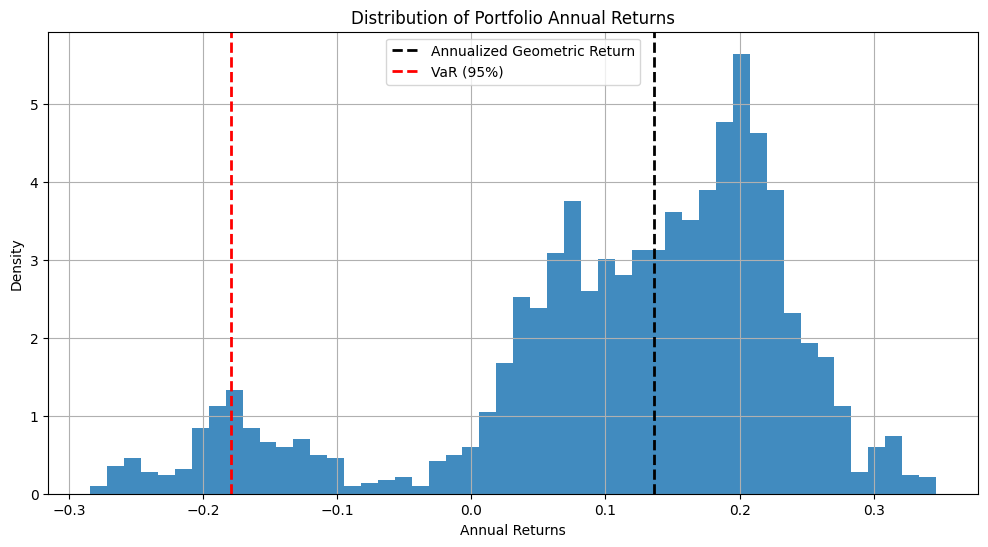

In [89]:
plt.figure(figsize=(12, 6))
plt.hist(annual_returns, bins=50, density=True, alpha=0.85)
plt.axvline(portf_annualized_geometric_return, color='black', linestyle='dashed', 
            linewidth=2, label='Annualized Geometric Return')
plt.axvline(-annual_var, color='red', linestyle='dashed', 
            linewidth=2, label=f'VaR ({CONFIDENCE_LEVEL:.0%})')
plt.xlabel('Annual Returns')
plt.ylabel('Density')
plt.title('Distribution of Portfolio Annual Returns')
plt.legend()
plt.grid(True)
plt.show()